In [1]:
import json
from functools import partial

import pandas as pd
import pyproj
import numpy as np
import shapely.ops as ops
from tqdm import tqdm
from shapely.geometry import shape

import matplotlib.pyplot as plt
import mplleaflet

from city_conf import city_mappings

## Map data results

In [ ]:
def find_polygon_area(geojson):
    geom = shape(geojson)
    geom_area = ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea',
                lat_1=geom.bounds[1],
                lat_2=geom.bounds[3]
            )
        ),
        geom)
    return geom_area.area / 1e6

In [ ]:
experiment_name = "data/2023-01-10/"

city_records = []
for country_map in city_mappings:
    for city in city_mappings[country_map]:
        city_name = list(city.keys())[0]
        osm_id = city[city_name]["osm_id"]
        try:
            with open(f"{experiment_name}/results/{city_name}.json", "r") as f:
                city_record = json.load(f)

            with open(f"{experiment_name}/city_polygons/{city_name.lower()}_polygon.geojson") as f:
                city_polygon = json.load(f)

            city_record["osm_id"] = osm_id
            city_record["area_km2"] = find_polygon_area(city_polygon)
            city_records.append(city_record)
        except:
            continue

In [ ]:
df = pd.DataFrame(city_records)

In [ ]:
df

In [ ]:
city_records_with_decay = []
for country_map in city_mappings:
    for city in city_mappings[country_map]:
        city_name = list(city.keys())[0]
        osm_id = city[city_name]["osm_id"]
        try:
            with open(f"{experiment_name}/results/{city_name}_decay.json", "r") as f:
                city_record = json.load(f)

            with open(f"{experiment_name}/city_polygons/{city_name.lower()}_polygon.geojson") as f:
                city_polygon = json.load(f)

            city_record["osm_id"] = osm_id
            city_record["area_km2"] = find_polygon_area(city_polygon)
            city_records_with_decay.append(city_record)
        except:
            continue

In [ ]:
df_decay = pd.DataFrame(city_records_with_decay)

In [ ]:
df_decay

In [ ]:
df["overall_road_length"] = df["total_cycling_road_length"] + df["total_road_length"]
df_decay["overall_road_length"] = df_decay["total_cycling_road_length"] + df_decay["total_road_length"]

In [ ]:
df["cycle_road_share"] = df["total_cycling_road_length"] / df["overall_road_length"]
df_decay["cycle_road_share"] = df_decay["total_cycling_road_length"] / df_decay["overall_road_length"]

In [ ]:
df["cycle_track_share"] = df["total_cycle_track_length"] / df["overall_road_length"]
df_decay["cycle_track_share"] = df_decay["total_cycle_track_length"] / df_decay["overall_road_length"]

In [ ]:
df["cycle_lane_share"] = df["total_cycle_lane_length"] / df["overall_road_length"]
df_decay["cycle_lane_share"] = df_decay["total_cycle_lane_length"] / df_decay["overall_road_length"]

In [ ]:
df["segregated_cycle_track_share"] = df["total_segregated_cycle_track_length"] / df["overall_road_length"]
df_decay["segregated_cycle_track_share"] = df_decay["total_segregated_cycle_track_length"] / df_decay[
    "overall_road_length"]

In [ ]:
df["rank_cycle_road_share"] = df["cycle_road_share"].rank(ascending=False).astype(int)
df["rank_cycle_track_share"] = df["cycle_track_share"].rank(ascending=False).astype(int)
df["rank_segregated_cycle_track_share"] = df["segregated_cycle_track_share"].rank(ascending=False).astype(int)

In [ ]:
df_decay["rank_cycle_road_share"] = df_decay["cycle_road_share"].rank(ascending=False).astype(int)
df_decay["rank_cycle_track_share"] = df_decay["cycle_track_share"].rank(ascending=False).astype(int)
df_decay["rank_segregated_cycle_track_share"] = df_decay["segregated_cycle_track_share"].rank(ascending=False).astype(
    int)

In [ ]:
merged = df.merge(df_decay, on=["city_name", "osm_id", "area_km2"], suffixes=["", "_decayed"])

# merged["overall_score"] = merged["cycle_road_share_decayed"] * merged["cycle_track_share_decayed"] #* merged[
#     "segregated_cycle_track_share_decayed"]
# merged["overall_score"] = merged["cycle_road_share"] * merged["segregated_cycle_track_share"]
merged["overall_score"] = merged["cycle_road_share_decayed"]
merged["overall_rank"] = merged["overall_score"].rank(ascending=False).astype(int)

In [ ]:
merged["parking_per_km2"] = merged['parking_counter'] / merged["area_km2"]

In [ ]:
# merged["rank_diff"] = (merged["cycle_road_share_decayed"] - merged["cycle_road_share"]) / merged["cycle_road_share"]

In [ ]:
merged["rank_diff"] = merged["rank_cycle_road_share"] - merged["rank_cycle_road_share_decayed"]

In [ ]:
merged.sort_values("rank_diff")

In [ ]:
### Print for web

In [ ]:
final = merged[
    ["city_name",
     "osm_id",
     "area_km2",
     "total_road_length",
     "total_cycling_road_length",
     "cycle_road_share",
     "cycle_track_share",
     "cycle_lane_share",
     "segregated_cycle_track_share",
     "cycle_road_share_decayed",
     "cycle_track_share_decayed",
     "segregated_cycle_track_share_decayed",
     "parking_per_km2",
     "overall_rank"]].round(3).rename(columns={
    "city_name": "City name",
    "osm_id": "OSM id",
    "area_km2": "Area (km2)",
    "total_road_length": "Navigable road length (km)",
    "total_cycling_road_length": "Navigable bike road length (km)",
    "cycle_road_share": "Cycle road share",
    "cycle_track_share": "Cycle track share",
    "cycle_lane_share": "Cycle lane share",
    "segregated_cycle_track_share": "Segregated track share",
    "cycle_road_share_decayed": "Cycle road share (weighted)",
    "cycle_track_share_decayed": "Cycle track share (weighted)",
    "segregated_cycle_track_share_decayed": "Segregated track share (weighted)",
    "parking_per_km2": "Parking spaces (per km2)",
    "overall_rank": "Rank"
})

In [ ]:
final_for_blog = merged[
    ["city_name",
     "osm_id",
     "area_km2",
     "total_road_length",
#      "total_cycling_road_length",
     "cycle_road_share_decayed",
#      "cycle_track_share",
#      "cycle_lane_share",
#      "segregated_cycle_track_share",
#      "cycle_road_share_decayed",
#      "cycle_track_share_decayed",
#      "segregated_cycle_track_share_decayed",
#      "parking_per_km2",
     "overall_rank"]
].round(3).rename(columns={"city_name": "City name", "osm_id": "OSM id", "area_km2": "Area (km2)", "total_road_length": "Navigable road length (km)", "cycle_road_share_decayed": "Cycle road share (weighted)", "overall_rank": "Rank"})

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
final.sort_values("Rank", ascending=True)

In [ ]:
# print(final.to_html(index=False))
with open("table.cs.html", "wt") as fout:
    fout.write(final.sort_values("Rank", ascending=True).to_html(index=False))
    
final.sort_values("Rank", ascending=True).to_csv("table.cs.csv", index=False)

In [ ]:
print(final_for_blog.sort_values("Rank", ascending=True).head(30).to_markdown(index=False))

In [ ]:
def generate_html(dataframe: pd.DataFrame):
    # get the table HTML from the dataframe
    table_html = dataframe.to_html(table_id="table")
    # construct the complete HTML with jQuery Data tables
    # You can disable paging or enable y scrolling on lines 20 and 21 respectively
    html = f"""
    <html>
    <header>
        <link href="https://cdn.datatables.net/1.11.5/css/jquery.dataTables.min.css" rel="stylesheet">
    </header>
    <body>
    {table_html}
    <script src="https://code.jquery.com/jquery-3.6.0.slim.min.js" integrity="sha256-u7e5khyithlIdTpu22PHhENmPcRdFiHRjhAuHcs05RI=" crossorigin="anonymous"></script>
    <script type="text/javascript" src="https://cdn.datatables.net/1.11.5/js/jquery.dataTables.min.js"></script>
    <script>
        $(document).ready( function () {{
            $('#table').DataTable({{
                // paging: false,    
                // scrollY: 400,
            }});
        }});
    </script>
    </body>
    </html>
    """
    # return the html
    return html

In [ ]:
html = generate_html(final.sort_values("Rank", ascending=True))
# write the HTML content to an HTML file
with open("table.cs.sortable.html", "wt") as fout:
    fout.write(html)

## Road network

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
from pyrosm import OSM
import pickle
import matplotlib.pyplot as plt

/home/dan/pex/venv3.10/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [17]:
osm_city = "Praha"
experiment_name = "data/2023-01-10/"

In [18]:
filepath = f'{experiment_name}/extracted_maps/{osm_city}.pbf'
osm = OSM(filepath)
nodes_driving, edges_driving = osm.get_network(nodes=True, network_type="cycling")
nodes_all, edges_all = osm.get_network(nodes=True, network_type="all")
drive_net = osm.get_network(network_type="cycling")

In [19]:
with open(f"{experiment_name}/results/{osm_city}_way_ids.pkl", "rb") as f:
     way_ids = pickle.load(f)

In [20]:
subset = drive_net[drive_net["id"].isin(list(way_ids.keys()))]

In [21]:
subset["length"].sum() / drive_net["length"].sum()

0.06300225503754009

In [22]:
lanes = subset[subset["highway"] != "cycleway"]

In [23]:
segregated_lanes = subset[subset["highway"] != "cycleway"]

In [24]:
subset.shape

(4402, 40)

In [25]:
subset["length"].sum()

473892.0

In [26]:
subset
subset.to_csv("foo.csv")

<Axes: >

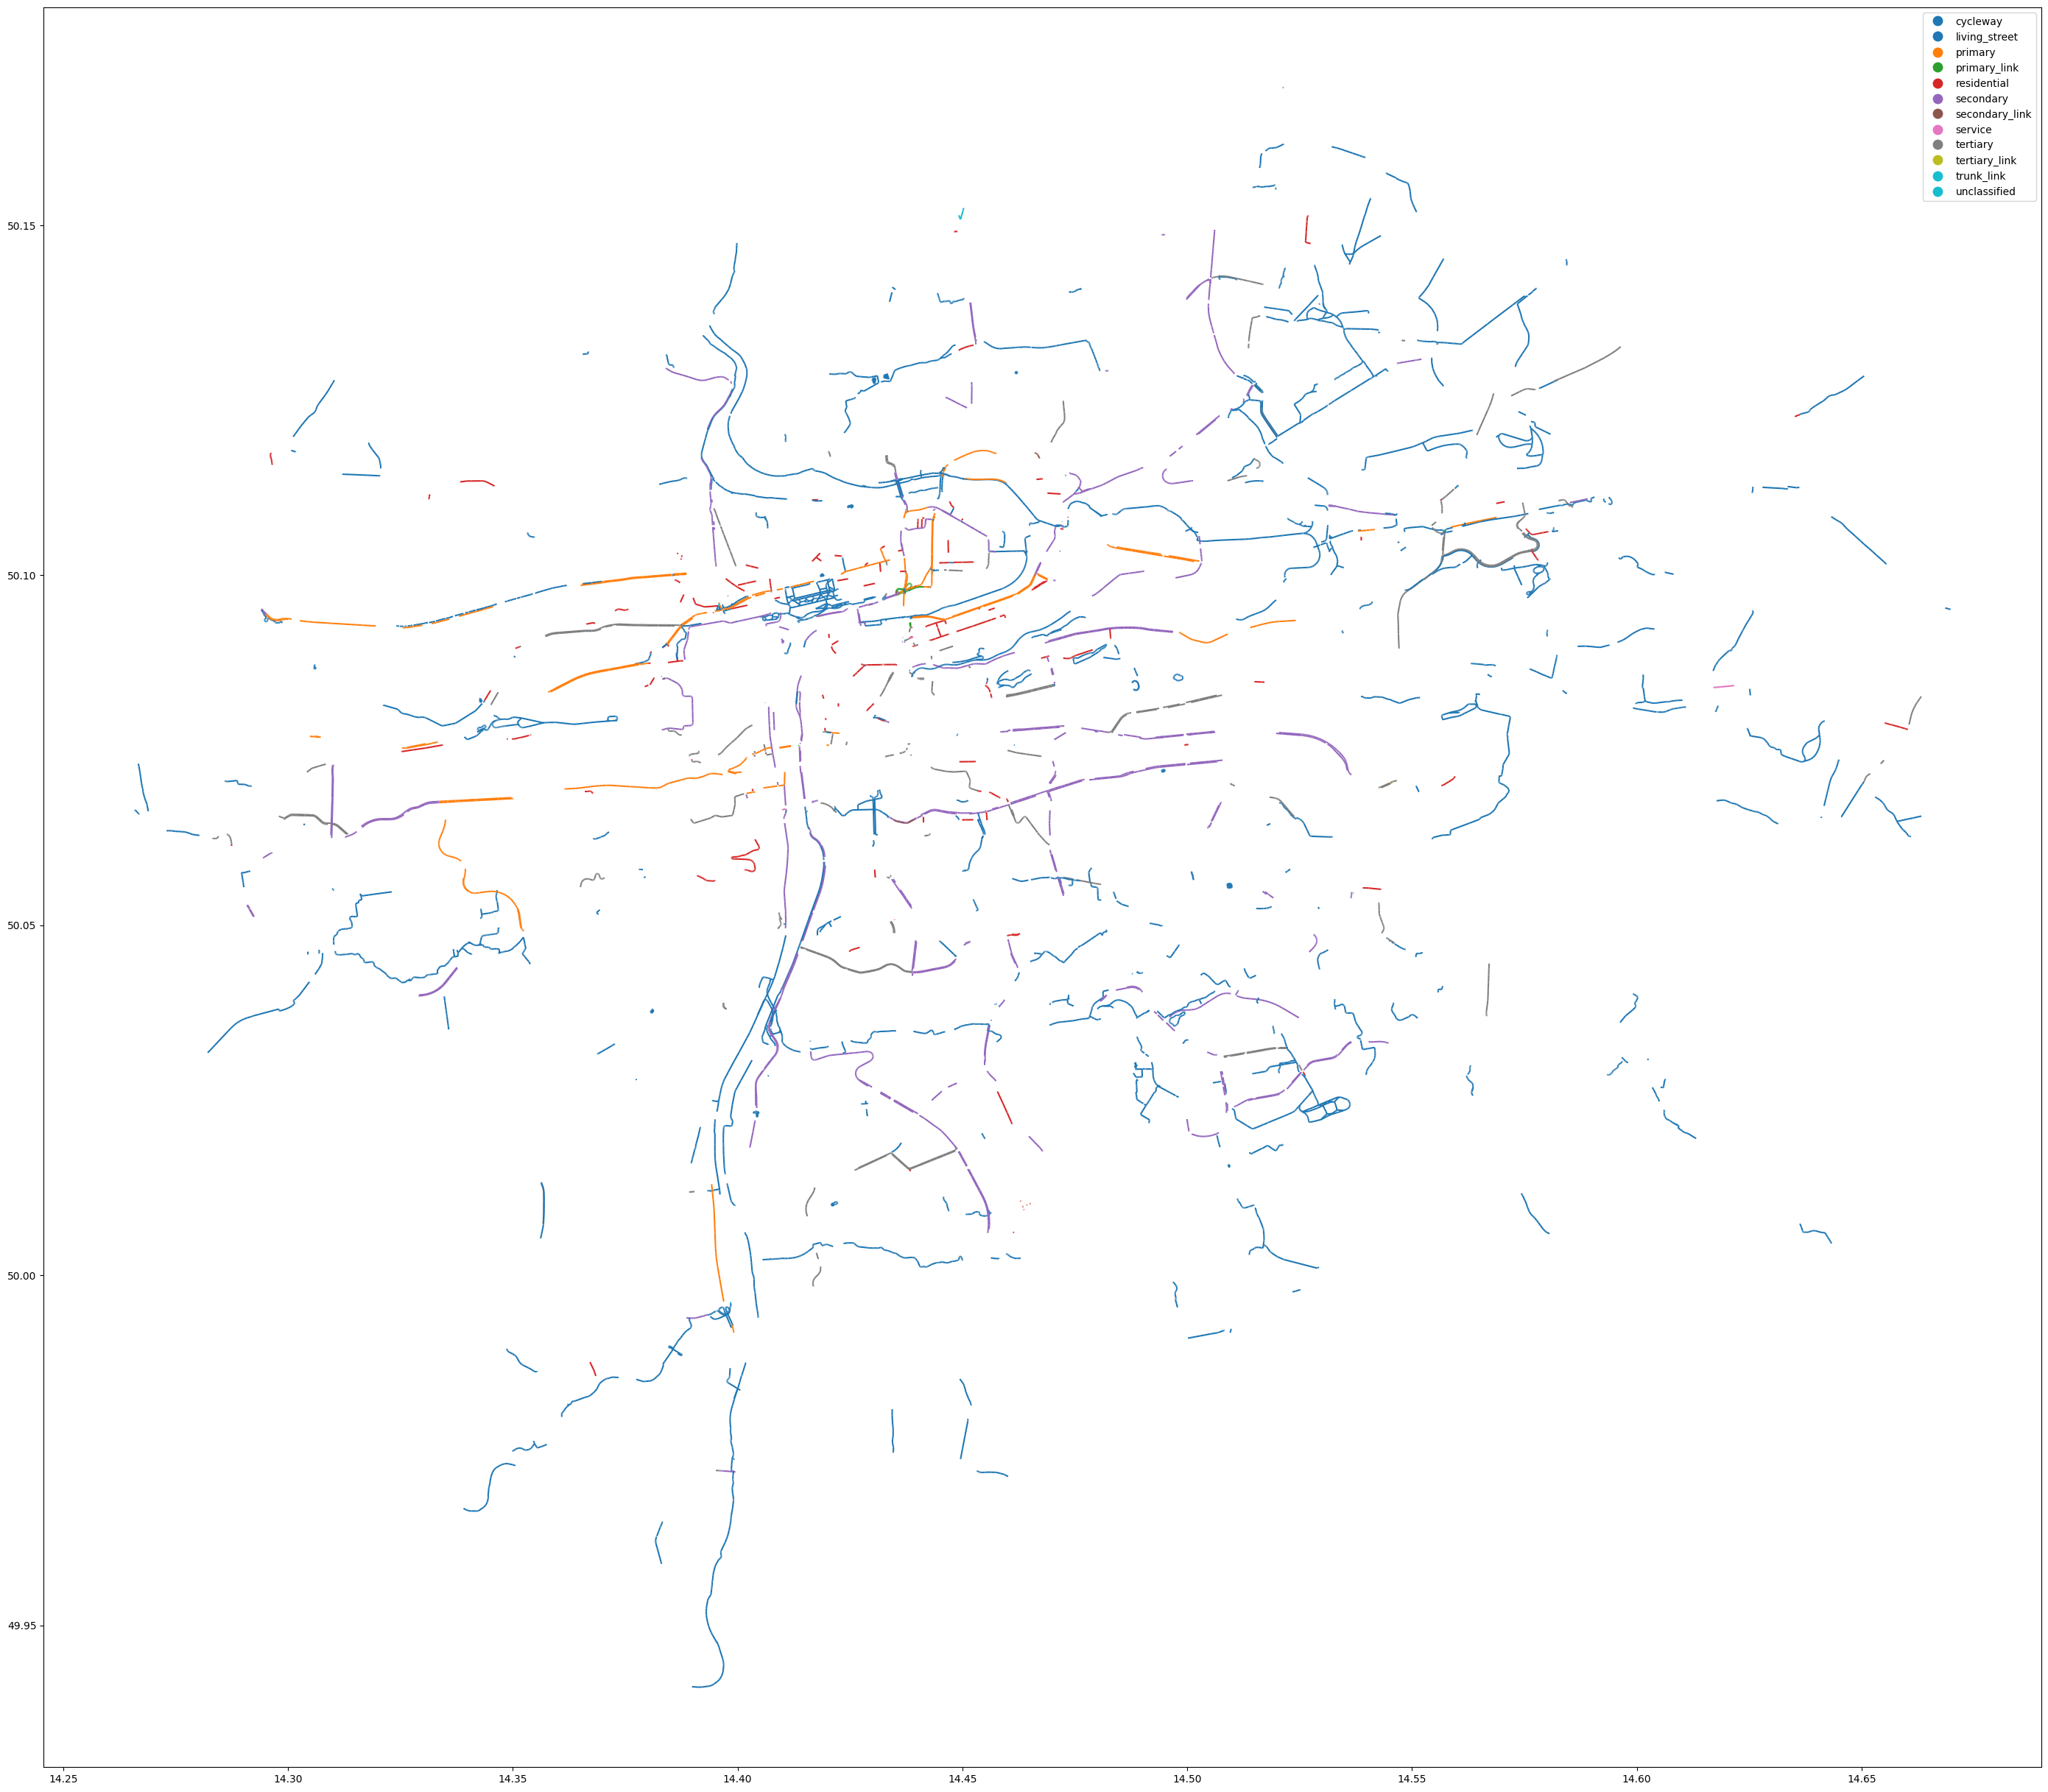

In [27]:
subset.plot(figsize=(35,35), column="highway", legend=True)

In [28]:
m = subset.explore()
m.save(f"{osm_city}.html")
m

In [ ]:
m = lanes.explore()
m.save(f"{osm_city}_lanes.html")
m

In [18]:
paths = subset[subset["highway"].isin(["path", "footway"])]

In [19]:
expanded = paths.explode()

/tmp/ipykernel_34060/2285191761.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  expanded = paths.explode()


In [20]:
way_to_coef = {}
i = 0

for w in way_ids:
    coef = way_ids[w]["weighted_distance"] / way_ids[w]["raw_distance"]
    way_to_coef[w] = coef

In [21]:
way_ids

{36839967: {'raw_distance': 151.35063324067363,
  'dist_from_centr': 0.835132874813939,
  'weighted_distance': 119.13724385423511},
 167475333: {'raw_distance': 668.9037229545746,
  'dist_from_centr': 0.6683949143501744,
  'weighted_distance': 577.104255138942},
 167475449: {'raw_distance': 96.12295127483577,
  'dist_from_centr': 0.7122803060264347,
  'weighted_distance': 80.9534215070177},
 168078135: {'raw_distance': 58.77539816563712,
  'dist_from_centr': 2.3370164076929836,
  'weighted_distance': 20.254243852876638},
 168078137: {'raw_distance': 53.49674425244213,
  'dist_from_centr': 1.9670884176174508,
  'weighted_distance': 22.59485368435577},
 168078147: {'raw_distance': 66.21131663533963,
  'dist_from_centr': 1.9857723870698436,
  'weighted_distance': 27.67907137506711},
 168078148: {'raw_distance': 543.2259343203715,
  'dist_from_centr': 2.165842271869585,
  'weighted_distance': 205.67804732717852},
 168078149: {'raw_distance': 122.03864914748019,
  'dist_from_centr': 2.35625

In [22]:
way_to_coef

{36839967: 0.7871605245601208,
 167475333: 0.862761314273823,
 167475449: 0.8421861837716031,
 168078135: 0.34460411132898505,
 168078137: 0.42235941644849373,
 168078147: 0.4180413980816941,
 168078148: 0.37862339467371303,
 168078149: 0.34097767355401654,
 168078151: 0.34224859907181426,
 168078152: 0.3489673767041904,
 168078160: 0.43069051823154336,
 168078161: 0.3225541645507348,
 216859357: 0.853590911462705,
 216859358: 0.9145302627431448,
 216859360: 0.8819218721821211,
 216859362: 0.8506205939589802,
 228527261: 1.0,
 255997488: 0.2903592897640941,
 255997506: 0.3502018115580313,
 255997516: 0.718365685592293,
 259713453: 0.9160779814262674,
 266946218: 0.8766558002743575,
 277788024: 0.2978791284791115,
 277788042: 0.3029932308182571,
 277788053: 0.29800312820212604,
 277788057: 0.3060944244678075,
 277788072: 0.303822293900395,
 277788073: 0.30284920820999883,
 277788096: 0.4168912298900044,
 277788126: 0.31377919816967725,
 296151466: 0.22445751549271967,
 303011508: 0.4061

In [ ]:
# way_ids_for_viz = [24773942, 162582750, 65180197, 214469336, 91896352, 213878646]
way_ids_for_viz = list(way_ids.keys())

In [ ]:
for w in way_ids_for_viz:
     print(w, way_to_coef[w])

In [ ]:
cycle_roads = drive_net[drive_net.id.isin(way_ids_for_viz)]

In [ ]:
expanded = cycle_roads.explode()

In [ ]:
way_to_coord = {}

In [ ]:
lngs = []
lats = []
ids = []
for geom, way_id in zip(expanded["geometry"], expanded["id"]):
    (start_lng, start_lat), (end_lng, end_lat) = geom.coords
    if way_id not in way_to_coord:
        way_to_coord[way_id] = (start_lat, start_lng)
    lngs.append((start_lng, end_lng))
    lats.append((start_lat, end_lat))
    ids.append(way_id)

In [ ]:
from shapely.geometry import Point, shape, Polygon, MultiPolygon
from functools import partial
import random
import pyproj
from shapely.ops import transform
import matplotlib.pyplot as plt

city_centroid = (13.3746469, 49.7492219)

In [ ]:
proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]

def create_circle_around_coord(lat, lon, km):
    b = geodesic_point_buffer(lat, lon, km)
    circle_lats = [x[1] for x in b]
    circle_lngs = [x[0] for x in b]
    return circle_lats, circle_lngs, b

In [ ]:
circle = create_circle_around_coord(city_centroid[1], city_centroid[0], 8)

In [ ]:
plt.scatter(city_centroid[0], city_centroid[1], color='gray', marker='o', s=200)
plt.plot(circle[1], circle[0], '-.', color="royalblue")
for i in tqdm(range(len(lngs))):
#     color = str(color_map(way_to_coef[ids[i]]))
     color = "blue"
     plt.plot(lngs[i], lats[i], linewidth=2.0, color=color)
# mplleaflet.show(tiles="cartodb_positron")
# mplleaflet.show()
plt.show()

## European map

In [ ]:
from city_conf import city_mappings

In [ ]:
city_centres = {}
for country in city_mappings:
    for city in city_mappings[country]:
        city_name = list(city.keys())[0]
        city_centre = city[city_name]['centre']
        city_centres[city_name] = city_centre

In [ ]:
from bs4 import BeautifulSoup
import requests

In [ ]:
html = "https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits"

In [ ]:
parsed_html = BeautifulSoup(requests.get(html).text)

In [ ]:
table = parsed_html.find('table')

In [ ]:
df = pd.read_html(html)[0]

In [ ]:
cities = []
pops = []
shares = []

for city_name, pop in zip(df["City"], df["Officialpopulation"]):
    if (city_name in city_centres) and (city_name in final["City name"].values):
        cities.append(city_name)
        pops.append(np.log(pop))
        shares.append(final[final["City name"] == city_name]["Cycle road share (weighted)"].iloc[0])

In [ ]:
plt.scatter(pops, shares)
m, b = np.polyfit(np.array(pops), np.array(shares), 1)
plt.plot(pops, m*np.array(pops) + b, '--', color='blue')
plt.xlabel("Log(population)")
plt.ylabel("Cycle road share (weighted)")
plt.show()

In [ ]:
np.exp(13)

In [ ]:
lats = [city_centres[c][0] for c in city_centres]
lngs = [city_centres[c][1] for c in city_centres]
shares = []
for city_name in city_centres:
    shares.append(final[final["city_name"] == city_name]["cycle_road_share_decayed"].iloc[0])
    
plt.scatter(lngs, lats, s=np.array(shares)*3000, alpha=0.6)
mplleaflet.show()